**Golf score and head-to-head predictions**

Use of historical golf scoring data for predictive analysis: 
- Build predictive models for professional golf (US PGA & European Tour) events using privately curated datasets with features engineered to represent form going into a contest

Golf is a very difficult sport to make predictions on due to a number of factors:
- **Large number of players:** Field sizes vary from 30-156 players per event
- **Weather:** Sun, wind and rain all play a big role in scoring.  Tournaments are played over 4 days with the weather constantly changing 
- **Variety of course setups:** Links / parkland / length / grass types / rough length / green speed etc.
- **Variety of locations:** Tournaments are played all over the world with different climates and conditions affecting players differently
- **Player form:** All professional players go through several peaks and troughs in their career.  These are very difficult to predict and a professional golfer can go from hero-to-zero and visa versa for no apparent reason
- **Luck:** The bounce of the ball can play a large roll in outcomes

As such, success rates of predictions are low relative to predictions in other sports, e.g. in Football, Tennis, Horse Racing etc.  This is reflected by the high odds that one can get from bookmakers - favorites typically come in around 6-12/1, midrange players around 20-80/1 and the rest can vary from 100-1000/1

- Goal:

Make score and head-to-head predictions using the latest ML & AI techniques.  These will be baselined against historical odds betting data to determine whether or not models can match / beat experts.

- Inspiration:

https://www.bloomberg.com/news/features/2018-05-03/the-gambler-who-cracked-the-horse-racing-code

https://www.bloomberg.com/news/videos/2020-01-09/the-man-who-beat-horse-racing-and-made-close-to-a-billion-dollars-video


**EUR Round-3&4: 2-ball head-to-head winner prediction:**




In [ ]:
#!pip install -U matplotlib

In [1]:
import pandas as pd
import numpy as np
import sys, os

run_colab=1

file_name = 'EUR_R34_2b_classification.csv'
tour_ind = ['EUR','EUR']
r_ind = [3,4]
g_ind = [2,2]


m_ho = 100
split = 0.15
k_fold = 10

if run_colab==1:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv('/content/drive/MyDrive/ML_Golf_Betting/GitHub/'+file_name)
else:
  data = pd.read_csv(file_name)

base_cols = list(data.columns)
print(f'({data.shape}) {base_cols}')

Mounted at /content/drive
((4017, 333)) ['Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind', 'pod_id', 'pod_pls', 'pl_back', 'pl_lay', 'm_c', 'DSLT', 'Length_n', 'Length_sg1', 'Length_sg2', 'Length_sg3', 'Length_sg4', 'Length_sgT', 'Length_n_1st_grp', 'Length_n_2nd_grp', 'Length_n_3rd_grp', 'Length_n_4th_grp', 'Length_n_5th_grp', 'Length_n_6th_grp', 'Length_n_7th_grp', 'Length_n_8th_grp', 'Length_n_9th_grp', 'Length_n_10th_grp', 'Length_n_W', 'Ptype_n', 'Ptype_sg1', 'Ptype_sg2', 'Ptype_sg3', 'Ptype_sg4', 'Ptype_sgT', 'Ptype_n_1st_grp', 'Ptype_n_2nd_grp', 'Ptype_n_3rd_grp', 'Ptype_n_4th_grp', 'Ptype_n_5th_grp', 'Ptype_n_6th_grp', 'Ptype_n_7th_grp', 'Ptype_n_8th_grp', 'Ptype_n_9th_grp', 'Ptype_n_10th_grp', 'Ptype_n_W', 'Region_n', 'Region_sg1', 'Region_sg2', 'Region_sg3', 'Region_sg4', 'Region_sgT', 'Region_n_1st_grp', 'Region_n_2nd_grp', 'Region_n_3rd_grp', 'Region_n_4th_grp', 'Region_n_5th_grp', 'Region_n_6th_grp', 'Region_n_7th_grp', 'Region_n_8th_grp', 'Region_n_9th_grp', 'Region_n_

In [2]:
print(data.shape)
data.head(3)

(4017, 333)


,Year_c,Month_c,Day_c,tName_c,date_ind,pod_id,pod_pls,pl_back,pl_lay,m_c,DSLT,Length_n,Length_sg1,Length_sg2,Length_sg3,Length_sg4,Length_sgT,Length_n_1st_grp,Length_n_2nd_grp,Length_n_3rd_grp,Length_n_4th_grp,Length_n_5th_grp,Length_n_6th_grp,Length_n_7th_grp,Length_n_8th_grp,Length_n_9th_grp,Length_n_10th_grp,Length_n_W,Ptype_n,Ptype_sg1,Ptype_sg2,Ptype_sg3,Ptype_sg4,Ptype_sgT,Ptype_n_1st_grp,Ptype_n_2nd_grp,Ptype_n_3rd_grp,Ptype_n_4th_grp,Ptype_n_5th_grp,Ptype_n_6th_grp,...,tb2_R3_ld_def,tb2_sg4,tb2_sgT,tb2_pT,tb2_fng,tb2_R4_ld_def,dslt_2,tb1_sg1,tb1_p1,tb1_R1_ld_def,tb1_sg2,tb1_p2,tb1_R2_ld_def,tb1_sg3,tb1_p3,tb1_R3_ld_def,tb1_sg4,tb1_sgT,tb1_pT,tb1_fng,tb1_R4_ld_def,dslt_1,R1_scr,R1_ld_def,R1_pos,R1_vFavg,R2_scr,R2_ld_def,R2_pos,R2_vFavg,R3_scr,R3_ld_def,R3_pos,R3_vFavg,R_scr,win_ind,fav_ind,mid_ind,weak_ind,tie_flag
0,2020,8,13,Celtic Classic (Wales),2020_8_13,2020_8_13_v0_d3_grp7_EUR,jake mcleod,3.85,4.30,132,7,19,-0.291626,0.438129,-0.957954,-0.233187,-0.163350,2,2,2,0,3,2,1,4,1,2,0,1,-1.259740,-2.441558,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,-30,0.000000,0.0,101,7,-30,8,-0.545455,70,-6,-1.05303,89,-11,0.000000,93,-30,0.000000,0.000000,93,6,-30,7,-6,-1,2,5.623077,-2,-3,6,1.961538,0,0,0,0.0,-2,0,0,0,1,0
1,2020,8,13,Celtic Classic (Wales),2020_8_13,2020_8_13_v0_d3_grp7_EUR,thomas detry,1.48,1.52,132,7,38,1.124829,1.824195,0.669569,1.078534,2.031949,11,7,8,3,5,1,1,0,0,2,0,2,-1.854702,4.232241,3.079392,2.250938,3.844782,1,0,1,0,0,0,...,-3,5.394366,10.0,2,0,-1,8,4.454545,2,-1,-3.05303,43,-8,3.287671,20,-10,-4.438356,-2.712329,56,4,-19,7,-4,-3,11,3.623077,-5,-2,3,4.961538,0,0,0,0.0,-3,1,1,0,0,0
2,0,0,0,0,2020_8_13,2020_8_13_v0_d3_grp7_EUR,tie,10.50,13.50,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0.000000,0.0,0,0,0,0,0.000000,0,0,0.00000,0,0,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0,0.000000,0,0,0,0.000000,0,0,0,0.0,0,0,0,0,0,0


In [3]:
data.isna().sum()

Year_c      0
Month_c     0
Day_c       0
tName_c     0
date_ind    0
           ..
win_ind     0
fav_ind     0
mid_ind     0
weak_ind    0
tie_flag    0
Length: 333, dtype: int64

In [4]:
data.nunique()

Year_c       6
Month_c     13
Day_c       30
tName_c     48
date_ind    83
            ..
win_ind      2
fav_ind      2
mid_ind      1
weak_ind     2
tie_flag     2
Length: 333, dtype: int64

In [5]:
data.describe(include='all').iloc[:,-10:-5]
#As of pandas v15.0, use the parameter, DataFrame.describe(include = 'all') to get a summary of all the columns when the dataframe has mixed column types. 
#The default behavior is to only provide a summary for the numerical columns.

,R3_scr,R3_ld_def,R3_pos,R3_vFavg,R_scr
count,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000
unique,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN
mean,-1.024645,-1.755788,3.642768,0.732390,-0.700523
std,2.005133,3.122157,7.449638,1.676783,2.556665
min,-10.000000,-20.000000,0.000000,-4.939394,-9.000000
25%,-1.000000,-3.000000,0.000000,0.000000,-2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,4.000000,0.569231,0.000000


In [6]:
# number of groups with favourite, mid and weak player identified based on bookies odds (when available)
m_grp_with_p012 = len(data)/ 3 
#Calculate win percentages for bookies favourite, mid and weakest players
fav_w = data.loc[(data['fav_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
mid_w = data.loc[(data['mid_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
weak_w = data.loc[(data['weak_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012


print('Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]')
print(f'fav_w={round(fav_w,4)}, mid_w={round(mid_w,4)}, weak_w={round(weak_w,4)} across {m_grp_with_p012} groups (*including ties)')

Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]
fav_w=0.525, mid_w=0.0, weak_w=0.3846 across 1339.0 groups (*including ties)


In [7]:
#Drop groups without favourite, mid and weak player identified
data_with_p012 = data.copy()

In [8]:
#Flatten each group (currently represented by 3 rows per group) to into a single row per group
tourn_cols = list(data_with_p012.columns[:5])
pl_col = data_with_p012.columns[6]
x_cols = list(data_with_p012.columns[7:-6])
y_cols = list(data_with_p012.columns[-6:])
pl_id = ['p0','p1','tie'] #tags to id players (fav, weak, tie)
p0_cols, p1_cols, tie_cols = [],[],[]
p012_cols = None
y_dict={0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}

df_flat = pd.DataFrame({'pod_id':list(data_with_p012['pod_id'].unique())})
for i in range(len(df_flat)):
#for i in [0]:
    if i==0: #initialize all columns
        for c in tourn_cols: df_flat[c]=[None]*len(df_flat)
        for pl in pl_id: 
          df_flat[pl+'_'+pl_col]=[None]*len(df_flat)
          if pl=='p0':p0_cols.append(pl+'_'+pl_col)
          if pl=='p1':p1_cols.append(pl+'_'+pl_col)
          if pl=='tie':tie_cols.append(pl+'_'+pl_col)    
        for pl in pl_id:
            if pl=='tie':
              df_flat[pl+'_'+x_cols[0]]=[None]*len(df_flat)
              tie_cols.append(pl+'_'+x_cols[0])
              df_flat[pl+'_'+x_cols[1]]=[None]*len(df_flat)
              tie_cols.append(pl+'_'+x_cols[1])
            else:
              for x in x_cols: 
                df_flat[pl+'_'+x]=[None]*len(df_flat)
                if pl=='p0':p0_cols.append(pl+'_'+x)
                if pl=='p1':p1_cols.append(pl+'_'+x)
        for pl in pl_id:
            if pl=='tie':
              df_flat[pl+'_'+y_cols[1]]=[None]*len(df_flat)
              tie_cols.append(pl+'_'+y_cols[1])
              df_flat[pl+'_'+y_cols[-1]]=[None]*len(df_flat)
              tie_cols.append(pl+'_'+y_cols[-1])
            else:
              for y in y_cols: 
                df_flat[pl+'_'+y]=[None]*len(df_flat)
                if pl=='p0':p0_cols.append(pl+'_'+y)
                if pl=='p1':p1_cols.append(pl+'_'+y)
        df_flat['y_target']=[None]*len(df_flat)

        p012_cols=[p0_cols, p1_cols, tie_cols]
        X_features = p0_cols[1:-6]+p1_cols[1:-6]+tie_cols[1:3]
        Y_classes = [p0_cols[-5], p1_cols[-5], tie_cols[3]]

    #Populate df_flat
    temp_df = data_with_p012[data_with_p012['pod_id']==df_flat.loc[i,'pod_id']].reset_index()
    df_flat.loc[i,tourn_cols] = temp_df.loc[0,tourn_cols]
    #get fav, weak & tie inds
    p0_ind = temp_df.loc[temp_df['fav_ind']==1].index[0]
    p1_ind = temp_df.loc[temp_df['weak_ind']==1].index[0]
    pt_ind = temp_df.loc[temp_df[pl_col]=='tie'].index[0]
    p012_ind=[p0_ind, p1_ind, pt_ind]
    for j in range(len(pl_id)):
      if pl_id[j]=='tie':
        df_flat.loc[i,p012_cols[j][0]] = temp_df.loc[p012_ind[j],pl_col]
        df_flat.loc[i,p012_cols[j][1:3]] = temp_df.loc[p012_ind[j],x_cols[0:2]].values
        df_flat.loc[i,p012_cols[j][3:]] = temp_df.loc[p012_ind[j],[y_cols[1], y_cols[-1]]].values
      else:
        df_flat.loc[i,p012_cols[j][0]] = temp_df.loc[p012_ind[j],pl_col]
        df_flat.loc[i,p012_cols[j][1:-6]] = temp_df.loc[p012_ind[j],x_cols].values
        df_flat.loc[i,p012_cols[j][-6:]] = temp_df.loc[p012_ind[j],y_cols].values
    #Calculate y_target
    win_lst = list(df_flat.loc[i,Y_classes])
    if [1,0,0]==win_lst: df_flat.loc[i,'y_target']=0
    if [0,1,0]==win_lst: df_flat.loc[i,'y_target']=1
    if [0,0,1]==win_lst: df_flat.loc[i,'y_target']=2

print(df_flat.columns)
print(df_flat.shape)
print(f'{len(p0_cols)}, {len(p1_cols)}, {len(tie_cols)}')

Index(['pod_id', 'Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind',
       'p0_pod_pls', 'p1_pod_pls', 'tie_pod_pls', 'p0_pl_back',
       ...
       'p0_tie_flag', 'p1_R_scr', 'p1_win_ind', 'p1_fav_ind', 'p1_mid_ind',
       'p1_weak_ind', 'p1_tie_flag', 'tie_win_ind', 'tie_tie_flag',
       'y_target'],
      dtype='object', length=666)
(1339, 666)
327, 327, 5


In [9]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [10]:
#Check if multiple favourites (players with tied starting odds) occur in any groups
#If they do (equal_df.shape>0) investigate to see whether fav_w percentage should be ammened and if so by how much 
equal_df = df_flat.loc[df_flat['p0_pl_back']==df_flat['p1_pl_back'], ['pod_id', 'p0_pl_back', 'p1_pl_back', 'p0_win_ind', 'p1_win_ind', 'tie_win_ind']]
equal_df.shape

(0, 6)

In [11]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Columns: 666 entries, pod_id to y_target
dtypes: object(666)
memory usage: 6.8+ MB


In [12]:
df_flat.isnull().values.any()

False

In [13]:
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
df_flat.to_csv('temp_flat.csv', index=False) 

In [14]:
df_flat.head(3)

,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,tie_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p1_tb1_p2,p1_tb1_R2_ld_def,p1_tb1_sg3,p1_tb1_p3,p1_tb1_R3_ld_def,p1_tb1_sg4,p1_tb1_sgT,p1_tb1_pT,p1_tb1_fng,p1_tb1_R4_ld_def,p1_dslt_1,p1_R1_scr,p1_R1_ld_def,p1_R1_pos,p1_R1_vFavg,p1_R2_scr,p1_R2_ld_def,p1_R2_pos,p1_R2_vFavg,p1_R3_scr,p1_R3_ld_def,p1_R3_pos,p1_R3_vFavg,tie_pl_back,tie_pl_lay,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,tie_win_ind,tie_tie_flag,y_target
0,2020_8_13_v0_d3_grp7_EUR,2020,8,13,Celtic Classic (Wales),2020_8_13,thomas detry,jake mcleod,tie,1.48,1.52,132,7,38,1.12483,1.82419,0.669569,1.07853,2.03195,11,7,8,3,5,1,1,0,0,2,0,2,-1.8547,4.23224,3.07939,2.25094,3.84478,1,0,1,0,...,89,-11,0,93,-30,0,0,93,6,-30,7,-6,-1,2,5.62308,-2,-3,6,1.96154,0,0,0,0,10.5,13.5,-3,1,1,0,0,0,-2,0,0,0,1,0,0,0,0
1,2018_9_6_v0_d3_grp8_EUR,2018,9,6,Omega European Masters (Switzerland) - Play Offs,2018_9_6,lucas bjerregaard,doug ghim,tie,1.73,1.75,156,7,8,2.03222,0.721335,0.495899,0.0875522,-0.113372,2,1,1,2,1,0,1,0,0,0,0,2,0.438312,3.65909,3.09091,-1.82468,1.03896,1,0,0,1,...,90,-13,0,95,-30,0,0,95,6,-30,14,-2,-4,18,2.69935,-5,-2,2,5.51634,0,0,0,0,9,11,-3,0,1,0,0,1,-3,0,0,0,1,1,1,1,2
2,2019_1_31_v0_d3_grp3_EUR,2019,1,31,Saudi International (Saudi Arabia),2019_1_31,bryson dechambeau,liam johnston,tie,1.25,1.34,132,7,33,1.07984,1.16997,0.377117,1.4497,3.86846,11,4,2,2,2,2,3,3,2,2,4,19,-0.292398,0.453583,1.44318,0.939505,1.3992,3,3,1,2,...,100,-13,0,107,-30,0,0,107,8,-30,34,0,-7,65,0.030303,-4,-7,12,5.25758,0,0,0,0,12,20,-2,1,1,0,0,0,0,0,0,0,1,0,0,0,0


In [15]:
#Veracity Check Data
#grp_id = '2020_8_13_v0_d3_grp7_EUR'
grp_id = '2021_9_9_v0_d4_grp9_EUR'
print(data_with_p012.loc[data_with_p012['pod_id']==grp_id, ['pod_pls','pl_back','Length_sg1','tb12_p1','R_scr', 'win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p0_pod_pls','p0_pl_back','p0_Length_sg1','p0_tb12_p1','p0_R_scr', 'p0_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p1_pod_pls','p1_pl_back','p1_Length_sg1','p1_tb12_p1','p1_R_scr', 'p1_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['tie_pod_pls','tie_pl_back','tie_pl_lay','tie_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, 'y_target'])

                pod_pls  pl_back  Length_sg1  tb12_p1  R_scr  win_ind
3957  francesco laporta     2.28    1.010358       25     -2        0
3958      laurie canter     1.95    0.988025       35     -5        1
3959                tie     8.60    0.000000        0      0        0

         p0_pod_pls p0_pl_back p0_Length_sg1 p0_tb12_p1 p0_R_scr p0_win_ind
1319  laurie canter       1.95      0.988025         35       -5          1

             p1_pod_pls p1_pl_back p1_Length_sg1 p1_tb12_p1 p1_R_scr p1_win_ind
1319  francesco laporta       2.28       1.01036         25       -2          0

     tie_pod_pls tie_pl_back tie_pl_lay tie_win_ind
1319         tie         8.6       10.5           0

1319    0
Name: y_target, dtype: object


In [16]:
#Generate datasets for 3-way data splits
# 1) ho_data
ho_data = df_flat.iloc[-m_ho:].copy()
ho_data.reset_index(inplace=True)
ho_data.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_ho_df = ho_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_ho_df = ho_data.loc[:,'y_target']     # y_target for p012
Y_ho_df_oh = ho_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_ho_df={type(X_ho_df)}, {X_ho_df.shape}, {X_ho_df.values[0,0:5]}')
print(f'Y_ho_df={type(Y_ho_df.values)}, {Y_ho_df.shape}, {Y_ho_df.values[0]}')
print(f'Y_ho_df_oh={type(Y_ho_df_oh.values)}, {Y_ho_df_oh.shape}, {Y_ho_df_oh.values[0]}')
#
print(ho_data.shape)
ho_data.head(1)

X_ho_df=<class 'pandas.core.frame.DataFrame'>, (100, 642), [1.97 2.08 124 35 25]
Y_ho_df=<class 'numpy.ndarray'>, (100,), 0
Y_ho_df_oh=<class 'numpy.ndarray'>, (100, 3), [1 0 0]
(100, 666)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,tie_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p1_tb1_p2,p1_tb1_R2_ld_def,p1_tb1_sg3,p1_tb1_p3,p1_tb1_R3_ld_def,p1_tb1_sg4,p1_tb1_sgT,p1_tb1_pT,p1_tb1_fng,p1_tb1_R4_ld_def,p1_dslt_1,p1_R1_scr,p1_R1_ld_def,p1_R1_pos,p1_R1_vFavg,p1_R2_scr,p1_R2_ld_def,p1_R2_pos,p1_R2_vFavg,p1_R3_scr,p1_R3_ld_def,p1_R3_pos,p1_R3_vFavg,tie_pl_back,tie_pl_lay,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,tie_win_ind,tie_tie_flag,y_target
0,2021_8_19_v0_d3_grp7_EUR,2021,8,19,D-D Real Czech Masters (Czech Republic),2021_8_19,johannes veerman,maverick antcliff,tie,1.97,2.08,124,35,25,1.2441,0.814638,0.719029,1.50182,2.25776,9,2,4,2,1,3,1,1,1,1,0,15,0.999441,0.592947,1.1318,2.3104,2.82704,4,2,2,1,...,5,-2,-3.05882,25,-8,-0.838235,0.279412,35,2,-9,14,-5,0,1,5.39837,-2,-3,5,2.08943,0,0,0,0,8.6,11,-4,1,1,0,0,0,2,0,0,0,1,0,0,0,0


In [17]:
#Generate datasets for 3-way data splits
# 2) all_data
all_data = df_flat.iloc[:-m_ho].copy()
#Generate X & Y Dataframes
X_all = all_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_all = all_data.loc[:,'y_target']     # y_target for p012
Y_all_oh = all_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_all={type(X_all)}, {X_all.shape}, {X_all.values[0,0:5]}')
print(f'Y_all={type(Y_all.values)}, {Y_all.shape}, {Y_all.values[0]}')
print(f'Y_all_oh={type(Y_all_oh.values)}, {Y_all_oh.shape}, {Y_all_oh.values[0]}')
#
print(all_data.shape)
all_data.iloc[-1:]

X_all=<class 'pandas.core.frame.DataFrame'>, (1239, 642), [1.48 1.52 132 7 38]
Y_all=<class 'numpy.ndarray'>, (1239,), 0
Y_all_oh=<class 'numpy.ndarray'>, (1239, 3), [1 0 0]
(1239, 666)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,tie_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p1_tb1_p2,p1_tb1_R2_ld_def,p1_tb1_sg3,p1_tb1_p3,p1_tb1_R3_ld_def,p1_tb1_sg4,p1_tb1_sgT,p1_tb1_pT,p1_tb1_fng,p1_tb1_R4_ld_def,p1_dslt_1,p1_R1_scr,p1_R1_ld_def,p1_R1_pos,p1_R1_vFavg,p1_R2_scr,p1_R2_ld_def,p1_R2_pos,p1_R2_vFavg,p1_R3_scr,p1_R3_ld_def,p1_R3_pos,p1_R3_vFavg,tie_pl_back,tie_pl_lay,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,tie_win_ind,tie_tie_flag,y_target
1238,2021_8_19_v0_d3_grp6_EUR,2021,8,19,D-D Real Czech Masters (Czech Republic),2021_8_19,dean burmester,tapio pulkkanen,tie,1.94,2.04,124,35,40,0.332271,0.728822,0.937785,-0.720508,0.841666,6,5,5,5,5,2,5,3,2,2,0,28,-0.0420619,0.524903,-0.616592,-0.0896573,-0.338519,4,1,2,4,...,33,-11,-1.52239,46,-16,3.74627,1.20896,25,1,-11,14,-4,-1,3,4.39837,-3,-3,5,3.08943,0,0,0,0,9,12,0,0,1,0,0,0,-6,1,0,0,1,0,0,0,1


In [18]:
#Generate datasets for 3-way data splits
# 3) train_primary (used to create train_current & validation_current for k-fold cross-validation)
train_primary = all_data.iloc[:int(len(all_data)*(1-split))].copy()
#Generate X & Y Dataframes
X_train_primary = train_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_train_primary = train_primary.loc[:,'y_target']     # y_target for p012
Y_train_primary_oh = train_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_train_primary={type(X_train_primary)}, {X_train_primary.shape}, {X_train_primary.values[0,0:5]}')
print(f'Y_train_primary={type(Y_train_primary.values)}, {Y_train_primary.shape}, {Y_train_primary.values[0]}')
print(f'Y_train_primary_oh={type(Y_train_primary_oh.values)}, {Y_train_primary_oh.shape}, {Y_train_primary_oh.values[0]}')
#
print(train_primary.shape)
train_primary.iloc[-1:]

X_train_primary=<class 'pandas.core.frame.DataFrame'>, (1053, 642), [1.48 1.52 132 7 38]
Y_train_primary=<class 'numpy.ndarray'>, (1053,), 0
Y_train_primary_oh=<class 'numpy.ndarray'>, (1053, 3), [1 0 0]
(1053, 666)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,tie_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p1_tb1_p2,p1_tb1_R2_ld_def,p1_tb1_sg3,p1_tb1_p3,p1_tb1_R3_ld_def,p1_tb1_sg4,p1_tb1_sgT,p1_tb1_pT,p1_tb1_fng,p1_tb1_R4_ld_def,p1_dslt_1,p1_R1_scr,p1_R1_ld_def,p1_R1_pos,p1_R1_vFavg,p1_R2_scr,p1_R2_ld_def,p1_R2_pos,p1_R2_vFavg,p1_R3_scr,p1_R3_ld_def,p1_R3_pos,p1_R3_vFavg,tie_pl_back,tie_pl_lay,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,tie_win_ind,tie_tie_flag,y_target
1052,2018_6_28_v0_d4_grp4_EUR,2018,6,28,Open de France (France),2018_6_28,shane lowry,thomas detry,tie,2.04,2.18,159,14,41,1.37392,0.443828,1.11713,0.207977,1.66725,9,8,3,6,3,0,5,3,4,0,0,15,0.513679,1.41453,0.921878,-0.437783,1.19935,3,3,1,3,...,16,-5,-3.88,53,-8,4.93333,2.81333,18,1,-7,21,3,-7,59,0.922581,-2,-7,22,4.52258,-2,-9,11,2.56923,8.6,9.8,-1,0,1,0,0,1,-1,0,0,0,1,1,1,1,2


In [19]:
#Generate datasets for 3-way data splits
# 4) test_primary
test_primary = all_data.iloc[int(len(all_data)*(1-split)):].copy()
test_primary.reset_index(inplace=True)
test_primary.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_test_primary = test_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_test_primary = test_primary.loc[:,'y_target']     # y_target for p012
Y_test_primary_oh = test_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_test_primary={type(X_test_primary)}, {X_test_primary.shape}, {X_test_primary.values[0,0:5]}')
print(f'Y_test_primary={type(Y_test_primary.values)}, {Y_test_primary.shape}, {Y_test_primary.values[0]}')
print(f'Y_test_primary_oh={type(Y_test_primary_oh.values)}, {Y_test_primary_oh.shape}, {Y_test_primary_oh.values[0]}')
#
print(test_primary.shape)
test_primary.iloc[-1:]
#test_primary.head(1)

X_test_primary=<class 'pandas.core.frame.DataFrame'>, (186, 642), [1.77 1.82 156 7 50]
Y_test_primary=<class 'numpy.ndarray'>, (186,), 1
Y_test_primary_oh=<class 'numpy.ndarray'>, (186, 3), [0 1 0]
(186, 666)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,tie_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p1_tb1_p2,p1_tb1_R2_ld_def,p1_tb1_sg3,p1_tb1_p3,p1_tb1_R3_ld_def,p1_tb1_sg4,p1_tb1_sgT,p1_tb1_pT,p1_tb1_fng,p1_tb1_R4_ld_def,p1_dslt_1,p1_R1_scr,p1_R1_ld_def,p1_R1_pos,p1_R1_vFavg,p1_R2_scr,p1_R2_ld_def,p1_R2_pos,p1_R2_vFavg,p1_R3_scr,p1_R3_ld_def,p1_R3_pos,p1_R3_vFavg,tie_pl_back,tie_pl_lay,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,tie_win_ind,tie_tie_flag,y_target
185,2021_8_19_v0_d3_grp6_EUR,2021,8,19,D-D Real Czech Masters (Czech Republic),2021_8_19,dean burmester,tapio pulkkanen,tie,1.94,2.04,124,35,40,0.332271,0.728822,0.937785,-0.720508,0.841666,6,5,5,5,5,2,5,3,2,2,0,28,-0.0420619,0.524903,-0.616592,-0.0896573,-0.338519,4,1,2,4,...,33,-11,-1.52239,46,-16,3.74627,1.20896,25,1,-11,14,-4,-1,3,4.39837,-3,-3,5,3.08943,0,0,0,0,9,12,0,0,1,0,0,0,-6,1,0,0,1,0,0,0,1


In [20]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [21]:
#Custom precision calc
def cal_prec(y_true, y_pred):
  prec = (y_true==y_pred).sum() / len(y_true)
  return prec

In [22]:
#Custom RoR calc
def calc_ror(y_true, y_pred, df, p_res=0):
  odds = df[['p0_pl_back','p1_pl_back','tie_pl_back']].values
  stake, prof=1,0
  for i in range(len(y_true)):
    if y_true[i]==y_pred[i]: 
      prof += stake * (odds[i, y_pred[i]]-1)
      if p_res==1: 
        temp_id_lst = list(df.loc[i,['p0_pod_pls','p1_pod_pls','tie_pod_pls','pod_id']])
        print(f'W y_true={y_true[i]}[{temp_id_lst[y_true[i]]}], y_pred={y_pred[i]}[{temp_id_lst[y_pred[i]]}], prof={prof}, odds={odds[i, y_pred[i]]}, {temp_id_lst}')
    else: 
      prof -= stake
      if p_res==1: 
        temp_id_lst = list(df.loc[i,['p0_pod_pls','p1_pod_pls','tie_pod_pls','pod_id']])
        print(f'L y_true={y_true[i]}[{temp_id_lst[y_true[i]]}], y_pred={y_pred[i]}[{temp_id_lst[y_pred[i]]}], prof={prof}, {temp_id_lst}')
  ror = prof / len(y_pred)
  return ror

In [23]:
# train_val function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as accuracy

def run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, df_init, clf, params, base):
  mod_name=base+'_'+params
  df_res = pd.read_csv('base_res.csv')
  #print(f'\nbase_res = {df_res.shape} {df_res.columns}')
  for i in range(k_fold):
    X_train, X_cv, Y_train, Y_cv, df_init_train, df_init_cv = train_test_split(X_train_primary.copy().values, Y_train_primary.copy().values, df_init.copy(), test_size=adj_split, shuffle=True)
    df_init_train.reset_index(inplace=True)
    df_init_train.drop('index', axis=1, inplace=True)
    df_init_cv.reset_index(inplace=True)
    df_init_cv.drop('index', axis=1, inplace=True)
    print(f'\n[{i}: {mod_name}] {X_train.shape}, {X_cv.shape}, {Y_train.shape}, {Y_cv.shape}, {df_init_train.shape}, {df_init_cv.shape}, {type(X_train)}, {type(Y_train)}, {type(df_init_train)}')
    print('df_init_train[0]='+str(df_init_train.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_train[0]='+str(Y_train[0])+', X_train[0,0]='+str(X_train[0,0])+
          ', df_init_cv[0]='+str(df_init_cv.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_cv[0]='+str(Y_cv[0])+', X_cv[0,0]='+str(X_cv[0,0]))
    # Normalize data
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)   
    X_cv_norm = scaler.transform(X_cv)
    # Fit model & predict
    model = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_train = model.predict(X_train_norm)
    pred_cv = model.predict(X_cv_norm)
    # Update df_res with results
    df_res = df_res.append(pd.Series(), ignore_index=True)
    row_ind = len(df_res)-1
    df_res.loc[row_ind,'model']=base
    df_res.loc[row_ind,'params']=params
    df_res.loc[row_ind,'m_train']=len(X_train)
    df_res.loc[row_ind,'m_cv']=len(X_cv)
    df_res.loc[row_ind,'pred_ror_train']=calc_ror(Y_train.astype('int'), pred_train, df_init_train)
    df_res.loc[row_ind,'pred_ror_cv']=calc_ror(Y_cv.astype('int'), pred_cv, df_init_cv)
    df_res.loc[row_ind,'fav_ror_train']=calc_ror(Y_train.astype('int'), np.zeros((len(pred_train))).astype('int'), df_init_train)
    df_res.loc[row_ind,'fav_ror_cv']=calc_ror(Y_cv.astype('int'), np.zeros((len(pred_cv))).astype('int'), df_init_cv)
    df_res.loc[row_ind,'pred_prec_train']=cal_prec(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'pred_prec_cv']=cal_prec(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'fav_prec_train']=cal_prec(Y_train.astype('int'), np.zeros((len(pred_train))))
    df_res.loc[row_ind,'fav_prec_cv']=cal_prec(Y_cv.astype('int'), np.zeros((len(pred_cv))))
    df_res.loc[row_ind,'acc_train']=accuracy(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'acc_cv']=accuracy(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'p0_freq_train']=(pred_train==0).sum()/len(pred_train)
    df_res.loc[row_ind,'p0_freq_cv']=(pred_cv==0).sum()/len(pred_cv)
    print('\n'+str(df_res.iloc[row_ind]))
  return df_res, mod_name

In [24]:
# Update results_df function
def update_df(df_results, mod_results, mod_name, params, red_col):
  if not(mod_name in list(df_results['model'])):
    df_results = df_results.append(pd.Series(), ignore_index=True)
    row_ind = len(df_results)-1
  else: 
    row_ind = df_results.index[df_results['model']==mod_name].values[0]
    df_results.iloc[row_ind]=None
  #Update df_results
  df_results.loc[row_ind,'model']=mod_name
  df_results.loc[row_ind,'params']=params
  df_results.loc[row_ind,'m_train']=mod_results['m_train'].mean()
  df_results.loc[row_ind,'m_cv']=mod_results['m_cv'].mean()
  df_results.loc[row_ind,'pred_ror_train']=mod_results['pred_ror_train'].mean()
  df_results.loc[row_ind,'pred_ror_cv']=mod_results['pred_ror_cv'].mean()
  df_results.loc[row_ind,'fav_ror_train']=mod_results['fav_ror_train'].mean()
  df_results.loc[row_ind,'fav_ror_cv']=mod_results['fav_ror_cv'].mean()
  df_results.loc[row_ind,'pred_prec_train']=mod_results['pred_prec_train'].mean()
  df_results.loc[row_ind,'pred_prec_cv']=mod_results['pred_prec_cv'].mean()
  df_results.loc[row_ind,'fav_prec_train']=mod_results['fav_prec_train'].mean()
  df_results.loc[row_ind,'fav_prec_cv']=mod_results['fav_prec_cv'].mean()
  df_results.loc[row_ind,'acc_train']=mod_results['acc_train'].mean()
  df_results.loc[row_ind,'acc_cv']=mod_results['acc_cv'].mean()
  df_results.loc[row_ind,'p0_freq_train']=mod_results['p0_freq_train'].mean()
  df_results.loc[row_ind,'p0_freq_cv']=mod_results['p0_freq_cv'].mean()
  df_results.loc[row_ind,'stdev_pred_ror_train']=mod_results['pred_ror_train'].std()
  df_results.loc[row_ind,'stdev_pred_ror_cv']=mod_results['pred_ror_cv'].std()
  df_results.loc[row_ind,'reduced_cols']=str(red_col)
  print('\ndf_results-'+str(row_ind)+'-'+str(df_results.iloc[row_ind]))

  return df_results

## **1) Evaluate using ALL Features**

In [25]:
#Evaluate models using all features
res_file = 'EUR_R34_2b_model_results.csv'
df_results = pd.read_csv(res_file)
print(f'df_results = {df_results.shape} {df_results.columns}')
adj_split = len(test_primary)/len(train_primary)

reduced_cols = X_features
n_iter, checkpoint = 0,50
##Model A)
ev = 0
if ev==1:
  from sklearn.svm import LinearSVC
  base = 'SVM LinearSVC_all'
  for cl in ['ovr']:                                                            #, 'crammer_singer']:
    #for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:                   #,50, 100, 500, 1000]:
    #for c in np.logspace(-3, 1, 100):
    for c in np.random.uniform(0,10,800):
      params = cl+'_'+str(c)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)
      n_iter+=1
      if n_iter%checkpoint==0:  #Output interim result
        df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
        try: df_results.drop('Unnamed: 0', inplace=True)
        except KeyError: None 
        df_results.to_csv(res_file, index=False)
  #Output final result
  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model B)
ev =  0
if ev==1:
  from sklearn.ensemble import RandomForestClassifier
  base = 'RandomForestClassifier_all'
  for ne in [100, 300]:                     #, 500, 800, 1200]:
    for md in [None, 2, 5, 8, 15, 25, 30]:
      for mss in [2, 5, 10, 15, 100]:
        for msl in [1, 2, 5, 10]:
          for bs in [True,False]:
            params = str(ne)+'_'+str(md)+'_'+str(mss)+'_'+str(msl)+'_'+str(bs)
            print(f'\nRunning {base} with hyperparameters {params}...')
            clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
            mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
            df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model C)
ev = 0
if ev==1:
  from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

  r_g=1
  if r_g==1:
    base = 'GaussianNB_all'
    for v in np.logspace(0,-9, num=1000):
      params = str(v)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = GaussianNB(var_smoothing=v)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)
  
    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

  r_m=0
  if r_m==1:
    base = 'MultinomialNB'
    params = ''
    print(f'\nRunning {base} with hyperparameters {params}...')
    clf = MultinomialNB()
    mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
    df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  r_b=1
  if r_b==1:
    base = 'BernoulliNB_all'
    for a in np.random.uniform(0,2,25):
      for b in np.random.uniform(0,2,25):
        for fp in [True, False]:
          params = str(a)+'_'+str(b)+'_'+str(fp)
          print(f'\nRunning {base} with hyperparameters {params}...')
          clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
          mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
          df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
try: df_results.drop('Unnamed: 0', inplace=True)
except KeyError: None 
df_results.to_csv(res_file, index=False)

df_results = (2897, 36) Index(['model', 'params', 'm_train', 'm_cv', 'm_test', 'm_ho',
       'pred_ror_train', 'pred_ror_cv', 'pred_ror_test', 'pred_ror_ho',
       'fav_ror_train', 'fav_ror_cv', 'fav_ror_test', 'fav_ror_ho',
       'pred_prec_train', 'pred_prec_cv', 'pred_prec_test', 'pred_prec_ho',
       'fav_prec_train', 'fav_prec_cv', 'fav_prec_test', 'fav_prec_ho',
       'acc_train', 'acc_cv', 'acc_test', 'acc_ho', 'p0_freq_train',
       'p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'stdev_pred_ror_train',
       'stdev_pred_ror_cv', 'reduced_cols', 'prod_mod', 'mu', 'sigma'],
      dtype='object')


In [26]:
df_results.head()

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_1.1321301224488856,ovr_1.1321301224488856,867,186,NaN,NaN,1.766438,0.067156,NaN,NaN,-0.044120,-0.035903,NaN,NaN,0.998847,0.469892,NaN,NaN,0.526759,0.533871,NaN,NaN,0.998847,0.469892,NaN,NaN,0.526067,0.510753,NaN,NaN,0.036411,0.094259,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,"[1.843833736884584, 1.9958111380145278, 135.49...","[0.1936053784751192, 0.3138456304408399, 29.72..."
1,BernoulliNB_all_1.3548955957564799_1.200414847...,1.3548955957564799_1.2004148479626569_True,867,186,NaN,NaN,0.774203,0.067097,NaN,NaN,-0.037017,-0.069011,NaN,NaN,0.658478,0.466667,NaN,NaN,0.531027,0.513978,NaN,NaN,0.658478,0.466667,NaN,NaN,0.467474,0.491398,NaN,NaN,0.036232,0.108239,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
2,BernoulliNB_all_0.5539221845798894_1.457862127...,0.5539221845798894_1.4578621270411996_True,867,186,NaN,NaN,0.824985,0.067091,NaN,NaN,-0.048977,-0.013263,NaN,NaN,0.658593,0.458065,NaN,NaN,0.524337,0.545161,NaN,NaN,0.658593,0.458065,NaN,NaN,0.459516,0.493548,NaN,NaN,0.043917,0.119488,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
3,RandomForestClassifier_all_300_25_100_2_True,300_25_100_2_True,867,186,NaN,NaN,1.428671,0.067032,NaN,NaN,-0.041334,-0.048887,NaN,NaN,0.866321,0.505914,NaN,NaN,0.528604,0.525269,NaN,NaN,0.866321,0.505914,NaN,NaN,0.494348,0.527419,NaN,NaN,0.075274,0.082930,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN
4,BernoulliNB_all_0.42461597773409254_1.23021697...,0.42461597773409254_1.230216978168519_True,867,186,NaN,NaN,0.814430,0.066995,NaN,NaN,-0.043845,-0.037183,NaN,NaN,0.655363,0.455914,NaN,NaN,0.527682,0.529570,NaN,NaN,0.655363,0.455914,NaN,NaN,0.459631,0.489785,NaN,NaN,0.036816,0.102313,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [27]:
#Best Model when pred_ror_cv is max (based on all features)
df_results['pred_ror_cv'] = pd.to_numeric(df_results['pred_ror_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_ror_ind = temp_df['pred_ror_cv'].idxmax()
top_ror_mod = df_results.loc[top_ror_ind, 'model']
df_results[df_results['model']==top_ror_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_1.1321301224488856,ovr_1.1321301224488856,867,186,NaN,NaN,1.766438,0.067156,NaN,NaN,-0.04412,-0.035903,NaN,NaN,0.998847,0.469892,NaN,NaN,0.526759,0.533871,NaN,NaN,0.998847,0.469892,NaN,NaN,0.526067,0.510753,NaN,NaN,0.036411,0.094259,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,"[1.843833736884584, 1.9958111380145278, 135.49...","[0.1936053784751192, 0.3138456304408399, 29.72..."


In [28]:
#Best Model when pred_prec_cv is max (based on all features)
df_results['pred_prec_cv'] = pd.to_numeric(df_results['pred_prec_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_prec_ind = temp_df['pred_prec_cv'].idxmax()
top_prec_mod = df_results.loc[top_prec_ind, 'model']
df_results[df_results['model']==top_prec_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
725,RandomForestClassifier_all_300_25_2_2_True,300_25_2_2_True,867,186,NaN,NaN,1.750559,0.027952,NaN,NaN,-0.04691,-0.022898,NaN,NaN,0.990081,0.551075,NaN,NaN,0.525144,0.541398,NaN,NaN,0.990081,0.551075,NaN,NaN,0.519377,0.862366,NaN,NaN,0.045117,0.101954,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [30]:
'''
Evaluate test data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv 
Train best model with X_train_primary, Y_train_primary & train_primary
Evaluate on X_test_primary, Y_test_primary, test_primary
'''
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

best_mod_ror = 'SVM LinearSVC_all_ovr_1.1321301224488856'
best_mod_prec = 'RandomForestClassifier_all_300_25_2_2_True'

for i in range(2):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    cl, c = 'ovr',1.1321301224488856
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  if i==1:
    best_mod = best_mod_prec
    ne,md,mss,msl,bs = 300,25,2,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a,b,fp = 1.1572123401615717, 1.6706388237626477, False
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_train_primary.copy().values, Y_train_primary.copy().values, train_primary.copy()
  X_test, Y_test, df_init_test = X_test_primary.copy().values, Y_test_primary.copy().values, test_primary.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_test_norm = scaler.transform(X_test)
  # Fit model & predict
  model = clf.fit(X_train_norm, Y_train.astype('int'))
  pred_test = model.predict(X_test_norm)
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_test']=len(X_test)
  df_results.loc[row_ind,'pred_ror_test']=calc_ror(Y_test.astype('int'), pred_test, df_init_test)
  df_results.loc[row_ind,'fav_ror_test']=calc_ror(Y_test.astype('int'), np.zeros((len(pred_test))).astype('int'), df_init_test)
  df_results.loc[row_ind,'pred_prec_test']=cal_prec(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'fav_prec_test']=cal_prec(Y_test.astype('int'), np.zeros((len(pred_test))))
  df_results.loc[row_ind,'acc_test']=accuracy(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'p0_freq_test']=(pred_test==0).sum()/len(pred_test)
  df_results.to_csv(res_file, index=False)

In [31]:
'''
Evaluate hold out data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv
Train best model with X_all, Y_all, all_data
Evaluate on X_ho, Y_ho, ho_data
'''
for i in range(2):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    cl, c = 'ovr',1.1321301224488856
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  if i==1:
    best_mod = best_mod_prec
    ne,md,mss,msl,bs = 300,25,2,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a, b, fp = 1.9000000000000001, 1.25, True
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne,md,mss,msl,bs = 300,30,5,1,False
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_all.copy().values, Y_all.copy().values, all_data.copy()
  X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_ho_norm = scaler.transform(X_ho)
  # Fit model & predict
  if i==0: 
    model_ror = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_ror = model_ror.predict(X_ho_norm)
    temp_pred = pred_ho_ror
  if i==1: 
    model_prec = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_prec = model_prec.predict(X_ho_norm)
    temp_pred = pred_ho_prec
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_ho']=len(X_ho)
  df_results.loc[row_ind,'pred_ror_ho']=calc_ror(Y_ho.astype('int'), temp_pred, df_init_ho)
  df_results.loc[row_ind,'fav_ror_ho']=calc_ror(Y_ho.astype('int'), np.zeros((len(temp_pred))).astype('int'), df_init_ho)
  df_results.loc[row_ind,'pred_prec_ho']=cal_prec(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'fav_prec_ho']=cal_prec(Y_ho.astype('int'), np.zeros((len(temp_pred))))
  df_results.loc[row_ind,'acc_ho']=accuracy(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'p0_freq_ho']=(temp_pred==0).sum()/len(temp_pred)
  df_results.loc[row_ind,'prod_mod']=best_mod
  df_results.loc[row_ind,'mu']=str(list(scaler.mean_))
  df_results.loc[row_ind,'sigma']=str(list(scaler.scale_))
  df_results.to_csv(res_file, index=False)

In [32]:
# save the model to disk
import pickle
filename_ror = 'ror_EUR_R[3, 4]_2b_all_data.sav'
pickle.dump(model_ror, open(filename_ror, 'wb'))
filename_prec = 'prec_EUR_R[3, 4]_2b_all_data.sav'
pickle.dump(model_prec, open(filename_prec, 'wb'))

In [33]:
df_results.loc[(df_results['model']==best_mod_ror) | (df_results['model']==best_mod_prec)]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,SVM LinearSVC_all_ovr_1.1321301224488856,ovr_1.1321301224488856,867,186,186.0,100.0,1.766438,0.067156,0.003118,0.1926,-0.04412,-0.035903,-0.018065,-0.1448,0.998847,0.469892,0.483871,0.55,0.526759,0.533871,0.543011,0.46,0.998847,0.469892,0.483871,0.55,0.526067,0.510753,0.462366,0.52,0.036411,0.094259,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",SVM LinearSVC_all_ovr_1.1321301224488856,"[1.843833736884584, 1.9958111380145278, 135.49...","[0.1936053784751192, 0.3138456304408399, 29.72..."
725,RandomForestClassifier_all_300_25_2_2_True,300_25_2_2_True,867,186,186.0,100.0,1.750559,0.027952,-0.057043,-0.0653,-0.04691,-0.022898,-0.018065,-0.1448,0.990081,0.551075,0.510753,0.47,0.525144,0.541398,0.543011,0.46,0.990081,0.551075,0.510753,0.47,0.519377,0.862366,0.849462,0.80,0.045117,0.101954,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",RandomForestClassifier_all_300_25_2_2_True,"[1.843833736884584, 1.9958111380145278, 135.49...","[0.1936053784751192, 0.3138456304408399, 29.72..."


In [34]:
# Create bar chart showing model vs fav performance across: 'p0_freq_train','p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'prec_train', 'prec_cv', 'prec_test', 'prec_ho', 'ror_train', 'ror_cv', 'ror_test', 'ror_ho'
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
    from charts_v2 import make_bars_all
    %load_ext autoreload
    %autoreload 2
  
from charts_v2 import make_bars_all

###**Best Model [All Features]**

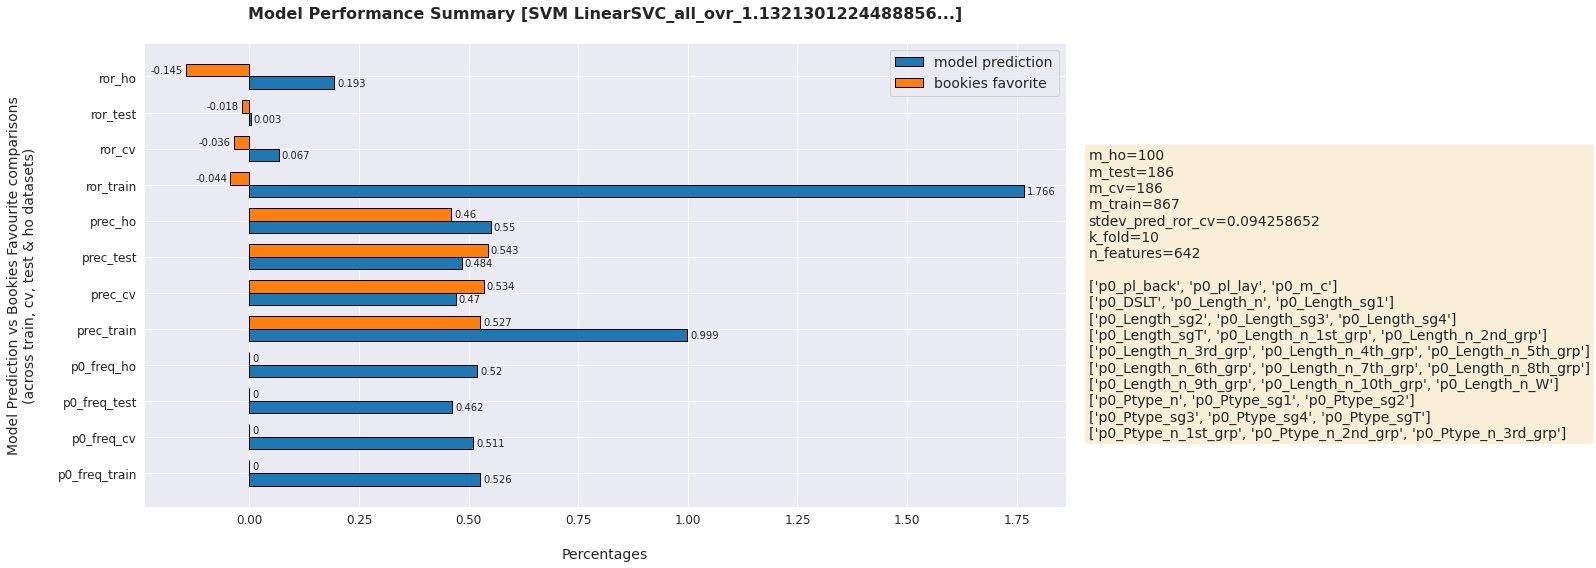

In [36]:
df_bar = make_bars_all(best_mod_ror, df_results, k_fold)

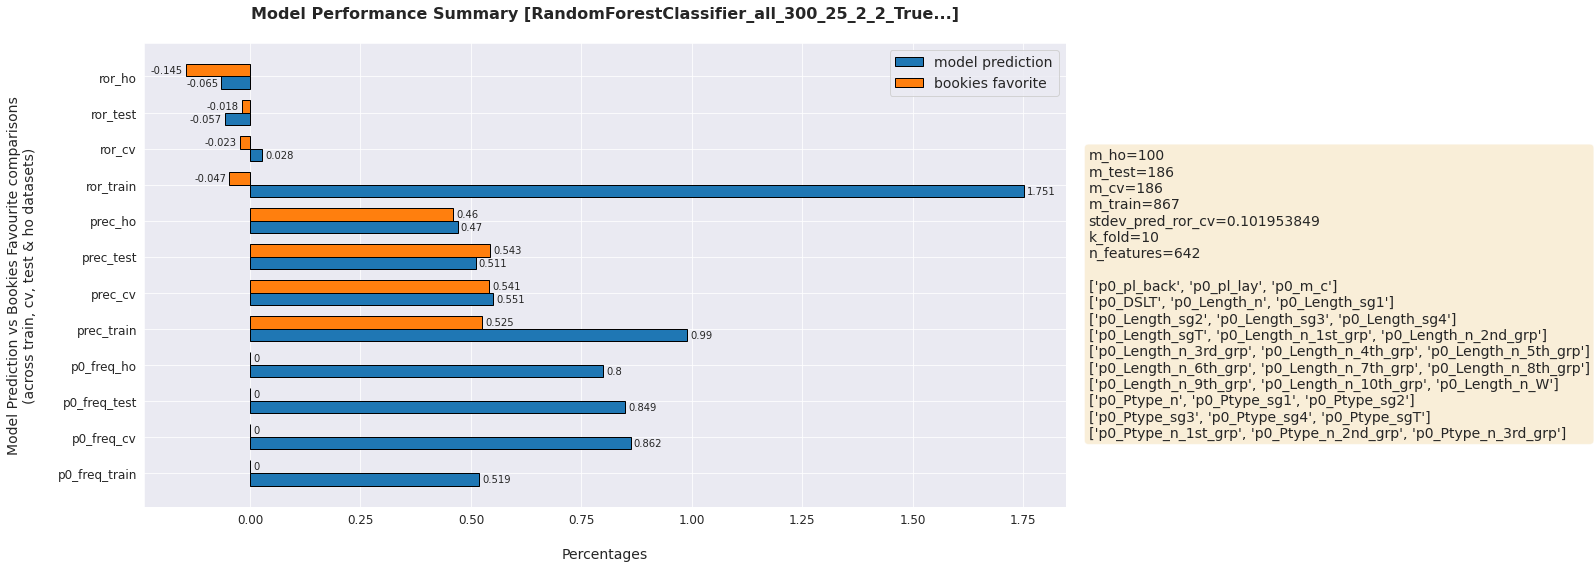

In [37]:
df_bar = make_bars_all(best_mod_prec, df_results, k_fold)

In [38]:
#Review ho results from model for all feature model
eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_ror, df_init_ho, p_res=1)
#eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_prec, df_init_ho, p_res=1)
print(f'\neval_ror_ho = {eval_ror_ho}')

L y_true=0[johannes veerman], y_pred=1[maverick antcliff], prof=-1, ['johannes veerman', 'maverick antcliff', 'tie', '2021_8_19_v0_d3_grp7_EUR']
W y_true=1[henrik stenson], y_pred=1[henrik stenson], prof=0.2799999999999998, odds=2.28, ['adrian meronk', 'henrik stenson', 'tie', '2021_8_19_v0_d3_grp8_EUR']
W y_true=0[sean crocker], y_pred=0[sean crocker], prof=1.0299999999999998, odds=1.75, ['sean crocker', 'sebastian soderberg', 'tie', '2021_8_19_v0_d3_grp9_EUR']
W y_true=1[stephen gallacher], y_pred=1[stephen gallacher], prof=2.9699999999999998, odds=2.94, ['thomas pieters', 'stephen gallacher', 'tie', '2021_1_21_v0_d4_grp0_EUR']
W y_true=0[adri arnaus], y_pred=0[adri arnaus], prof=3.83, odds=1.86, ['adri arnaus', 'richard bland', 'tie', '2021_1_21_v0_d4_grp1_EUR']
L y_true=1[fabrizio zanotti], y_pred=0[victor perez], prof=2.83, ['victor perez', 'fabrizio zanotti', 'tie', '2021_1_21_v0_d4_grp2_EUR']
L y_true=0[matt wallace], y_pred=1[mikko korhonen], prof=1.83, ['matt wallace', 'mikko 

In [40]:
#Review ho results from loaded model
from sklearn.svm import LinearSVC
import ast, pickle

#Load model and normalization parameters
loaded_model = pickle.load(open('ror_EUR_R[3, 4]_2b_all_data.sav', 'rb'))  #ror_PGA_R1_3b_all_data.sav / prec_PGA_R1_3b_all_data.sav
mu = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='SVM LinearSVC_all_ovr_1.1321301224488856', 'mu'])[0])
sigma = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='SVM LinearSVC_all_ovr_1.1321301224488856', 'sigma'])[0])
X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
#Normalize data
eval_norm = np.divide(np.subtract(X_ho, mu), sigma)
#Predict from loaded model & evaluate
eval_pred = loaded_model.predict(eval_norm)
eval_ror_loaded = calc_ror(Y_ho.astype('int'), eval_pred, df_init_ho, p_res=1)
try: print(f'\neval_ror_loaded = {eval_ror_loaded} ... eval_ror_ho = {eval_ror_ho}')
except NameError: print(f'\neval_ror_loaded = {eval_ror_loaded}')

L y_true=0[johannes veerman], y_pred=1[maverick antcliff], prof=-1, ['johannes veerman', 'maverick antcliff', 'tie', '2021_8_19_v0_d3_grp7_EUR']
W y_true=1[henrik stenson], y_pred=1[henrik stenson], prof=0.2799999999999998, odds=2.28, ['adrian meronk', 'henrik stenson', 'tie', '2021_8_19_v0_d3_grp8_EUR']
W y_true=0[sean crocker], y_pred=0[sean crocker], prof=1.0299999999999998, odds=1.75, ['sean crocker', 'sebastian soderberg', 'tie', '2021_8_19_v0_d3_grp9_EUR']
W y_true=1[stephen gallacher], y_pred=1[stephen gallacher], prof=2.9699999999999998, odds=2.94, ['thomas pieters', 'stephen gallacher', 'tie', '2021_1_21_v0_d4_grp0_EUR']
W y_true=0[adri arnaus], y_pred=0[adri arnaus], prof=3.83, odds=1.86, ['adri arnaus', 'richard bland', 'tie', '2021_1_21_v0_d4_grp1_EUR']
L y_true=1[fabrizio zanotti], y_pred=0[victor perez], prof=2.83, ['victor perez', 'fabrizio zanotti', 'tie', '2021_1_21_v0_d4_grp2_EUR']
L y_true=0[matt wallace], y_pred=1[mikko korhonen], prof=1.83, ['matt wallace', 'mikko 